# Tool Selection Evaluation - Multi-Model Comparison

**Models Evaluated:**
- `gemini-2.0-flash` (Balanced - baseline)
- `gemini-2.5-pro` (High quality)
- `gemini-2.0-flash-lite` (Speed optimized)


## Setup and Imports

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import numpy as np
from typing import List, Dict, Set, Any
from dataclasses import dataclass
import json
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Agent imports
from agents.fundamental_agent import FundamentalAgent
from agents.sentiment_agent import SentimentAgent
from agents.valuation_agent import ValuationAgent

print("Imports successful")

Imports successful


In [2]:
# Define the available tools for each agent
AGENT_TOOLS = {
    "fundamental": {
        "resolve_ticker_symbol",
        "finance_report_pull",
        "rag_analysis"
    },
    "sentiment": {
        "resolve_ticker_symbol",
        "get_recent_articles",
        "get_article_sentiment"
    },
    "valuation": {
        "resolve_ticker_symbol",
        "get_stock_data",
        "analyze_stock_metrics"
    }
}

# All unique tools across all agents
ALL_TOOLS = set()
for tools in AGENT_TOOLS.values():
    ALL_TOOLS.update(tools)

print("Agent Tool Configuration:")
for agent, tools in AGENT_TOOLS.items():
    print(f"  {agent.capitalize()} Agent: {sorted(tools)}")
print(f"\nAll unique tools: {sorted(ALL_TOOLS)}")

Agent Tool Configuration:
  Fundamental Agent: ['finance_report_pull', 'rag_analysis', 'resolve_ticker_symbol']
  Sentiment Agent: ['get_article_sentiment', 'get_recent_articles', 'resolve_ticker_symbol']
  Valuation Agent: ['analyze_stock_metrics', 'get_stock_data', 'resolve_ticker_symbol']

All unique tools: ['analyze_stock_metrics', 'finance_report_pull', 'get_article_sentiment', 'get_recent_articles', 'get_stock_data', 'rag_analysis', 'resolve_ticker_symbol']


## Define Test Cases

In [3]:
FUNDAMENTAL_TEST_CASES = [
    # Basic queries with ticker - prompt instructs to call both tools
    {
        "query": "Analyze the financial health of 1155.KL",
        "expected_tools": ["finance_report_pull", "rag_analysis"],
        "description": "Direct ticker - financial health analysis"
    },
    {
        "query": "What are the fundamentals of 1023.KL?",
        "expected_tools": ["finance_report_pull", "rag_analysis"],
        "description": "Direct ticker - general fundamentals"
    },
    {
        "query": "Review the financial statements of 5819.KL",
        "expected_tools": ["finance_report_pull", "rag_analysis"],
        "description": "Direct ticker - financial statements"
    },
    
    # Queries with company names (need ticker resolution + both analysis tools)
    {
        "query": "Analyze the financial health of Maybank",
        "expected_tools": ["resolve_ticker_symbol", "finance_report_pull", "rag_analysis"],
        "description": "Company name - requires ticker resolution"
    },
    {
        "query": "What is the profitability of CIMB Group?",
        "expected_tools": ["resolve_ticker_symbol", "finance_report_pull", "rag_analysis"],
        "description": "Company name - profitability focus"
    },
    {
        "query": "Evaluate Public Bank's balance sheet",
        "expected_tools": ["resolve_ticker_symbol", "finance_report_pull", "rag_analysis"],
        "description": "Company name - balance sheet focus"
    },
    {
        "query": "How is Tenaga Nasional's cash flow?",
        "expected_tools": ["resolve_ticker_symbol", "finance_report_pull", "rag_analysis"],
        "description": "Company name - cash flow focus"
    },
    {
        "query": "Assess the debt levels of Petronas Gas",
        "expected_tools": ["resolve_ticker_symbol", "finance_report_pull", "rag_analysis"],
        "description": "Company name - debt analysis"
    },
    
    # Specific financial metric queries
    {
        "query": "What is the ROE of Hong Leong Bank?",
        "expected_tools": ["resolve_ticker_symbol", "finance_report_pull", "rag_analysis"],
        "description": "Specific metric - ROE"
    },
    {
        "query": "Calculate the current ratio for IHH Healthcare",
        "expected_tools": ["resolve_ticker_symbol", "finance_report_pull", "rag_analysis"],
        "description": "Specific metric - current ratio"
    },
    {
        "query": "What are the profit margins of Press Metal?",
        "expected_tools": ["resolve_ticker_symbol", "finance_report_pull", "rag_analysis"],
        "description": "Specific metric - profit margins"
    },
    
    # Investment recommendation queries
    {
        "query": "Should I invest in Gamuda based on financials?",
        "expected_tools": ["resolve_ticker_symbol", "finance_report_pull", "rag_analysis"],
        "description": "Investment recommendation based on fundamentals"
    },
    {
        "query": "Is RHB Bank financially stable?",
        "expected_tools": ["resolve_ticker_symbol", "finance_report_pull", "rag_analysis"],
        "description": "Financial stability assessment"
    },
    {
        "query": "Evaluate the growth potential of Sunway based on fundamentals",
        "expected_tools": ["resolve_ticker_symbol", "finance_report_pull", "rag_analysis"],
        "description": "Growth potential from fundamentals"
    },
    
    # Comparative/complex queries
    {
        "query": "Analyze YTL Corporation's revenue trends",
        "expected_tools": ["resolve_ticker_symbol", "finance_report_pull", "rag_analysis"],
        "description": "Revenue trend analysis"
    },
    {
        "query": "What are the key financial risks for Axiata?",
        "expected_tools": ["resolve_ticker_symbol", "finance_report_pull", "rag_analysis"],
        "description": "Financial risk identification"
    },
    {
        "query": "Review MISC Berhad's quarterly performance",
        "expected_tools": ["resolve_ticker_symbol", "finance_report_pull", "rag_analysis"],
        "description": "Quarterly performance review"
    },
    {
        "query": "How has Nestle Malaysia's earnings changed?",
        "expected_tools": ["resolve_ticker_symbol", "finance_report_pull", "rag_analysis"],
        "description": "Earnings change analysis"
    },
]

print(f"Fundamental Agent: {len(FUNDAMENTAL_TEST_CASES)} test cases defined")

Fundamental Agent: 18 test cases defined


### Sentiment Agent Test Cases

In [4]:
SENTIMENT_TEST_CASES = [
    # Basic sentiment queries with ticker
    {
        "query": "What is the market sentiment for 1155.KL?",
        "expected_tools": ["get_recent_articles", "get_article_sentiment"],
        "description": "Direct ticker - general sentiment"
    },
    {
        "query": "Analyze the news sentiment of 1023.KL",
        "expected_tools": ["get_recent_articles", "get_article_sentiment"],
        "description": "Direct ticker - news sentiment"
    },
    {
        "query": "How is the media coverage for 5347.KL?",
        "expected_tools": ["get_recent_articles", "get_article_sentiment"],
        "description": "Direct ticker - media coverage"
    },
    
    # Queries with company names (need ticker resolution)
    {
        "query": "What is the sentiment around Maybank?",
        "expected_tools": ["resolve_ticker_symbol", "get_recent_articles", "get_article_sentiment"],
        "description": "Company name - requires ticker resolution"
    },
    {
        "query": "Analyze news sentiment for CIMB",
        "expected_tools": ["resolve_ticker_symbol", "get_recent_articles", "get_article_sentiment"],
        "description": "Company name - news sentiment"
    },
    {
        "query": "How is the market feeling about Public Bank?",
        "expected_tools": ["resolve_ticker_symbol", "get_recent_articles", "get_article_sentiment"],
        "description": "Company name - market feeling"
    },
    {
        "query": "What are people saying about Tenaga Nasional?",
        "expected_tools": ["resolve_ticker_symbol", "get_recent_articles", "get_article_sentiment"],
        "description": "Company name - public opinion"
    },
    {
        "query": "Is there positive news about Petronas Chemicals?",
        "expected_tools": ["resolve_ticker_symbol", "get_recent_articles", "get_article_sentiment"],
        "description": "Company name - positive news check"
    },
    
    # Recent news specific queries
    {
        "query": "Get recent news articles about Hong Leong Bank",
        "expected_tools": ["resolve_ticker_symbol", "get_recent_articles", "get_article_sentiment"],
        "description": "Recent news request"
    },
    {
        "query": "What news has been published about IHH Healthcare recently?",
        "expected_tools": ["resolve_ticker_symbol", "get_recent_articles", "get_article_sentiment"],
        "description": "Recent publications query"
    },
    {
        "query": "Show me the latest headlines for Press Metal",
        "expected_tools": ["resolve_ticker_symbol", "get_recent_articles"],
        "description": "Latest headlines request"
    },
    
    # Sentiment trend queries
    {
        "query": "Is the sentiment for Gamuda improving or declining?",
        "expected_tools": ["resolve_ticker_symbol", "get_recent_articles", "get_article_sentiment"],
        "description": "Sentiment trend analysis"
    },
    {
        "query": "Has there been negative news about RHB Bank?",
        "expected_tools": ["resolve_ticker_symbol", "get_recent_articles", "get_article_sentiment"],
        "description": "Negative news check"
    },
    {
        "query": "What is the overall mood around Maxis?",
        "expected_tools": ["resolve_ticker_symbol", "get_recent_articles", "get_article_sentiment"],
        "description": "Overall mood assessment"
    },
    
    # Investment sentiment queries
    {
        "query": "Based on news, should I be worried about Axiata?",
        "expected_tools": ["resolve_ticker_symbol", "get_recent_articles", "get_article_sentiment"],
        "description": "Concern assessment from news"
    },
    {
        "query": "Is media sentiment bullish or bearish on YTL Power?",
        "expected_tools": ["resolve_ticker_symbol", "get_recent_articles", "get_article_sentiment"],
        "description": "Bullish/bearish sentiment"
    },
    {
        "query": "Analyze investor sentiment for Sime Darby",
        "expected_tools": ["resolve_ticker_symbol", "get_recent_articles", "get_article_sentiment"],
        "description": "Investor sentiment analysis"
    },
    {
        "query": "What do news articles say about SD Guthrie's outlook?",
        "expected_tools": ["resolve_ticker_symbol", "get_recent_articles", "get_article_sentiment"],
        "description": "Outlook from news"
    },
]

print(f"Sentiment Agent: {len(SENTIMENT_TEST_CASES)} test cases defined")

Sentiment Agent: 18 test cases defined


### Valuation Agent Test Cases

In [5]:
VALUATION_TEST_CASES = [
    # Basic valuation queries with ticker - analyze_stock_metrics fetches data internally
    {
        "query": "Analyze the risk metrics for 1155.KL",
        "expected_tools": ["analyze_stock_metrics"],
        "description": "Direct ticker - risk metrics"
    },
    {
        "query": "What is the volatility of 1023.KL?",
        "expected_tools": ["analyze_stock_metrics"],
        "description": "Direct ticker - volatility"
    },
    {
        "query": "Calculate the Sharpe ratio for 5819.KL",
        "expected_tools": ["analyze_stock_metrics"],
        "description": "Direct ticker - Sharpe ratio"
    },
    
    # Queries with company names (need ticker resolution)
    {
        "query": "What is the risk profile of Maybank?",
        "expected_tools": ["resolve_ticker_symbol", "analyze_stock_metrics"],
        "description": "Company name - risk profile"
    },
    {
        "query": "Analyze CIMB's stock volatility",
        "expected_tools": ["resolve_ticker_symbol", "analyze_stock_metrics"],
        "description": "Company name - volatility analysis"
    },
    {
        "query": "What is the Value at Risk for Public Bank?",
        "expected_tools": ["resolve_ticker_symbol", "analyze_stock_metrics"],
        "description": "Company name - VaR calculation"
    },
    {
        "query": "Calculate the maximum drawdown for Tenaga Nasional",
        "expected_tools": ["resolve_ticker_symbol", "analyze_stock_metrics"],
        "description": "Company name - max drawdown"
    },
    {
        "query": "How risky is investing in Petronas Gas?",
        "expected_tools": ["resolve_ticker_symbol", "analyze_stock_metrics"],
        "description": "Company name - risk assessment"
    },
    
    # Historical data and price performance queries - analyze_stock_metrics includes this
    {
        "query": "Get the historical stock prices for Hong Leong Bank",
        "expected_tools": ["resolve_ticker_symbol", "get_stock_data"],
        "description": "Historical price data request"
    },
    {
        "query": "Show me IHH Healthcare's price performance over the past year",
        "expected_tools": ["resolve_ticker_symbol", "analyze_stock_metrics"],
        "description": "Price performance query"
    },
    {
        "query": "What are the trading volumes for Press Metal?",
        "expected_tools": ["resolve_ticker_symbol", "analyze_stock_metrics"],
        "description": "Volume data request"
    },
    
    # Risk-adjusted return queries
    {
        "query": "Evaluate the risk-adjusted returns of Gamuda",
        "expected_tools": ["resolve_ticker_symbol", "analyze_stock_metrics"],
        "description": "Risk-adjusted returns"
    },
    {
        "query": "Is RHB Bank a low-risk investment?",
        "expected_tools": ["resolve_ticker_symbol", "analyze_stock_metrics"],
        "description": "Low-risk assessment"
    },
    {
        "query": "What is the annualized return for Sunway?",
        "expected_tools": ["resolve_ticker_symbol", "analyze_stock_metrics"],
        "description": "Annualized return calculation"
    },
    
    # Investor profile queries
    {
        "query": "Is YTL Corporation suitable for a conservative investor?",
        "expected_tools": ["resolve_ticker_symbol", "analyze_stock_metrics"],
        "description": "Conservative investor suitability"
    },
    {
        "query": "Analyze Axiata's risk for an aggressive portfolio",
        "expected_tools": ["resolve_ticker_symbol", "analyze_stock_metrics"],
        "description": "Aggressive portfolio risk"
    },
    {
        "query": "What is the downside risk of MISC Berhad?",
        "expected_tools": ["resolve_ticker_symbol", "analyze_stock_metrics"],
        "description": "Downside risk analysis"
    },
    {
        "query": "Calculate risk metrics for IOI Corporation",
        "expected_tools": ["resolve_ticker_symbol", "analyze_stock_metrics"],
        "description": "General risk metrics"
    },
]

print(f"Valuation Agent: {len(VALUATION_TEST_CASES)} test cases defined")

Valuation Agent: 18 test cases defined


### Summary of Test Cases

In [6]:
# Combine all test cases
ALL_TEST_CASES = {
    "fundamental": FUNDAMENTAL_TEST_CASES,
    "sentiment": SENTIMENT_TEST_CASES,
    "valuation": VALUATION_TEST_CASES
}

print("=" * 50)
print("TEST CASE SUMMARY")
print("=" * 50)
total = 0
for agent, cases in ALL_TEST_CASES.items():
    print(f"{agent.capitalize()} Agent: {len(cases)} test cases")
    total += len(cases)
print(f"\nTotal: {total} test cases")

TEST CASE SUMMARY
Fundamental Agent: 18 test cases
Sentiment Agent: 18 test cases
Valuation Agent: 18 test cases

Total: 54 test cases


## Tool Call Capture Wrapper

In [ ]:
from typing import Callable
import functools

class ToolCallTracker:
    def __init__(self):
        self.calls = []
        self.current_query = None
    
    def reset(self):
        # Reset tracking when calling new query
        self.calls = []
    
    def record_call(self, tool_name: str, args: dict = None):
        self.calls.append({
            "tool": tool_name,
            "args": args
        })
    
    def get_called_tools(self) -> List[str]:
        return list(dict.fromkeys([c["tool"] for c in self.calls]))
    
    def get_called_tools_set(self) -> Set[str]:
        return set(c["tool"] for c in self.calls)


# Global tracker instance
tool_tracker = ToolCallTracker()

print("ToolCallTracker initialized")

ToolCallTracker initialized


In [ ]:
def run_agent_and_capture_tools(
    agent, 
    query: str, 
    tracker: ToolCallTracker,
    max_retries: int = 3,
    retry_delay: float = 5.0
) -> Dict[str, Any]:
    import uuid
    import time
    tracker.reset()
    
    for attempt in range(max_retries):
        try:
            # Generate unique thread_id for this test
            thread_id = f"eval_{uuid.uuid4().hex[:8]}"
            
            # Use the agent's invoke method
            result = agent.invoke(query, thread_id=thread_id)
            
            # Extract tool calls from messages in the result
            called_tools = []
            messages = result.get("messages", [])
            
            for msg in messages:
                # Check for tool_calls attribute in AIMessage
                if hasattr(msg, 'tool_calls') and msg.tool_calls:
                    for tc in msg.tool_calls:
                        # Handle different formats of tool call objects
                        if isinstance(tc, dict):
                            tool_name = tc.get('name', 'unknown')
                        elif hasattr(tc, 'name'):
                            tool_name = tc.name
                        else:
                            tool_name = str(tc)
                        
                        if tool_name not in called_tools:
                            called_tools.append(tool_name)
                            tracker.record_call(tool_name)
                
                # Check for ToolMessage (indicates tool was executed)
                msg_type = getattr(msg, 'type', None) or type(msg).__name__
                if 'ToolMessage' in str(msg_type) or msg_type == 'tool':
                    tool_name = getattr(msg, 'name', None)
                    if tool_name and tool_name not in called_tools:
                        called_tools.append(tool_name)
                        tracker.record_call(tool_name)
            
            return {
                "success": True,
                "response": result,
                "called_tools": tracker.get_called_tools(),
                "called_tools_set": tracker.get_called_tools_set(),
                "attempts": attempt + 1,
                "error": None
            }
            
        except Exception as e:
            error_msg = str(e)
            
            # Check if it's a retryable error (rate limit, timeout, etc.)
            is_retryable = any(x in error_msg.lower() for x in [
                'rate limit', 'quota', 'timeout', 'temporarily', 'unavailable',
                'service', '429', '503', '500', 'deadline'
            ])
            
            if attempt < max_retries - 1 and is_retryable:
                wait_time = retry_delay * (2 ** attempt)  # Exponential backoff
                print(f"    ⚠ Attempt {attempt + 1} failed: {error_msg[:80]}")
                print(f"    Retrying in {wait_time:.1f}s...")
                time.sleep(wait_time)
                continue
            else:
                # Final attempt failed or non-retryable error
                import traceback
                return {
                    "success": False,
                    "error": error_msg,
                    "error_type": "API_ERROR" if is_retryable else "OTHER_ERROR",
                    "traceback": traceback.format_exc(),
                    "called_tools": [],
                    "called_tools_set": set(),
                    "attempts": attempt + 1
                }
    
    # Should never reach here, but just in case
    return {
        "success": False,
        "error": "Max retries exceeded",
        "error_type": "MAX_RETRIES",
        "called_tools": [],
        "called_tools_set": set(),
        "attempts": max_retries
    }

print("Agent runner function with retry logic defined")

Agent runner function with retry logic defined


## Evaluation Metrics

In [ ]:
@dataclass
class ToolSelectionMetrics:
    accuracy: float
    precision: float
    recall: float
    f1_score: float
    total_cases: int
    exact_matches: int
    
    def __repr__(self):
        return (
            f"ToolSelectionMetrics(\n"
            f"  Accuracy:  {self.accuracy:.2%}\n"
            f"  Precision: {self.precision:.2%}\n"
            f"  Recall:    {self.recall:.2%}\n"
            f"  F1 Score:  {self.f1_score:.2%}\n"
            f"  Exact Matches: {self.exact_matches}/{self.total_cases}\n"
            f")"
        )


def calculate_tool_selection_metrics(
    expected_tools_list: List[Set[str]],
    actual_tools_list: List[Set[str]],
    all_possible_tools: Set[str]
) -> ToolSelectionMetrics:
    total_cases = len(expected_tools_list)
    
    # Count exact matches (all tools match exactly)
    exact_matches = sum(
        1 for exp, act in zip(expected_tools_list, actual_tools_list)
        if exp == act
    )
    
    # Accuracy = exact matches / total cases
    accuracy = exact_matches / total_cases if total_cases > 0 else 0
    
    # For Precision, Recall, F1: use micro-averaging
    # TP: tool expected AND called
    # FP: tool NOT expected BUT called
    # FN: tool expected BUT NOT called
    
    tp = 0  # True Positives
    fp = 0  # False Positives
    fn = 0  # False Negatives
    
    for expected, actual in zip(expected_tools_list, actual_tools_list):
        tp += len(expected & actual)  # Correctly selected tools
        fp += len(actual - expected)  # Tools selected but not expected
        fn += len(expected - actual)  # Tools expected but not selected
    
    # Calculate metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return ToolSelectionMetrics(
        accuracy=accuracy,
        precision=precision,
        recall=recall,
        f1_score=f1_score,
        total_cases=total_cases,
        exact_matches=exact_matches
    )

print("Metrics calculation functions defined")

Metrics calculation functions defined


## Run Evaluation


In [ ]:
import time
import json
import os

def save_results_incremental(all_results, filepath="results/tool_selection_results_temp.json"):
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    
    # Convert sets to lists for JSON serialization
    export_data = {}
    for model_name, model_data in all_results.items():
        export_data[model_name] = {}
        for agent_name, agent_data in model_data.items():
            results_list = []
            for r in agent_data["results"]:
                result_copy = r.copy()
                result_copy["expected"] = list(r["expected"])
                result_copy["actual"] = list(r["actual"])
                results_list.append(result_copy)
            
            export_data[model_name][agent_name] = {
                "results": results_list,
                "test_cases_completed": len(results_list)
            }
    
    with open(filepath, 'w') as f:
        json.dump(export_data, f, indent=2)


def run_evaluation_for_agent(
    agent_name: str,
    agent_instance,
    test_cases: List[Dict],
    model_name: str,
    all_results: Dict,  # For incremental saving
    delay_between_calls: float = 2.0
) -> Dict[str, Any]:
    results = []
    expected_tools_list = []
    actual_tools_list = []
    
    print(f"\n{'='*60}")
    print(f"Evaluating {agent_name.upper()} Agent with {model_name}")
    print(f"{'='*60}")
    
    for i, test_case in enumerate(test_cases):
        query = test_case["query"]
        expected = set(test_case["expected_tools"])
        description = test_case["description"]
        
        print(f"\n[{i+1}/{len(test_cases)}] {description}")
        print(f"  Query: {query[:60]}..." if len(query) > 60 else f"  Query: {query}")
        
        # Run agent and capture tools
        result = run_agent_and_capture_tools(
            agent_instance, 
            query, 
            tool_tracker,
            max_retries=3,
            retry_delay=5.0
        )
        
        if result["success"]:
            actual = result["called_tools_set"]
            match = "EXACT" if expected == actual else "PARTIAL" if expected & actual else "MISS"
            
            print(f"  Expected: {sorted(expected)}")
            print(f"  Actual:   {sorted(actual)}")
            print(f"  Result:   {match} (attempts: {result.get('attempts', 1)})")
            
            results.append({
                "query": query,
                "description": description,
                "expected": expected,
                "actual": actual,
                "match": match,
                "success": True,
                "attempts": result.get("attempts", 1),
                "error": None,
                "error_type": None
            })
            
            expected_tools_list.append(expected)
            actual_tools_list.append(actual)
        else:
            print(f"  ❌ ERROR ({result.get('error_type', 'UNKNOWN')}): {result['error'][:80]}")
            print(f"  Attempts: {result.get('attempts', 0)}")
            
            results.append({
                "query": query,
                "description": description,
                "expected": expected,
                "actual": set(),
                "match": "ERROR",
                "success": False,
                "attempts": result.get("attempts", 0),
                "error": result["error"],
                "error_type": result.get("error_type", "UNKNOWN")
            })
            
            # Don't add to metrics lists - will be excluded from accuracy calculation
        
        # Save incrementally after each query
        if model_name not in all_results:
            all_results[model_name] = {}
        all_results[model_name][agent_name] = {
            "results": results,
            "expected_tools_list": expected_tools_list,
            "actual_tools_list": actual_tools_list
        }
        save_results_incremental(all_results)
        
        # Delay to avoid rate limiting
        if i < len(test_cases) - 1:
            time.sleep(delay_between_calls)
    
    # Calculate metrics (excluding errors)
    if expected_tools_list and actual_tools_list:
        metrics = calculate_tool_selection_metrics(
            expected_tools_list,
            actual_tools_list,
            AGENT_TOOLS[agent_name]
        )
    else:
        # All failed
        metrics = ToolSelectionMetrics(
            accuracy=0.0,
            precision=0.0,
            recall=0.0,
            f1_score=0.0,
            total_cases=0,
            exact_matches=0
        )
    
    # Count errors separately
    error_count = sum(1 for r in results if not r["success"])
    
    return {
        "agent": agent_name,
        "model": model_name,
        "results": results,
        "metrics": metrics,
        "error_count": error_count,
        "total_cases": len(test_cases),
        "successful_cases": len(expected_tools_list)
    }

print("Evaluation runner function with incremental saving defined")

Evaluation runner function with incremental saving defined


### Initialize Agents

In [11]:
# Models to evaluate
MODELS_TO_TEST = [
    "gemini-2.0-flash",
    "gemini-2.5-pro",
    "gemini-2.0-flash-lite"
]

# Initialize agents for each model
from agents.base import get_llm

AGENTS_BY_MODEL = {}

print("Initializing agents for each model...")
print("=" * 60)

for model_name in MODELS_TO_TEST:
    print(f"\n{model_name}:")
    
    # Create LLM instance for this model
    llm = get_llm(model_name=model_name)
    print(f"  ✓ LLM initialized")
    
    # Initialize agents with this LLM
    fundamental_agent = FundamentalAgent(llm=llm)
    sentiment_agent = SentimentAgent(llm=llm)
    valuation_agent = ValuationAgent(llm=llm)
    
    AGENTS_BY_MODEL[model_name] = {
        "fundamental": fundamental_agent,
        "sentiment": sentiment_agent,
        "valuation": valuation_agent
    }
    
    print(f"  ✓ All agents initialized")

print("\n" + "=" * 60)
print(f"Ready to evaluate {len(MODELS_TO_TEST)} models x 3 agents")
print(f"Total: {len(MODELS_TO_TEST) * 3} agent-model combinations")
print("=" * 60)

Initializing agents for each model...

gemini-2.0-flash:
Initializing Gemini model: gemini-2.0-flash
Successfully connected to Gemini model: gemini-2.0-flash
  ✓ LLM initialized
  ✓ All agents initialized

gemini-2.5-pro:
Initializing Gemini model: gemini-2.5-pro
Successfully connected to Gemini model: gemini-2.5-pro
  ✓ LLM initialized
  ✓ All agents initialized

gemini-2.0-flash-lite:
Initializing Gemini model: gemini-2.0-flash-lite
Successfully connected to Gemini model: gemini-2.0-flash-lite
  ✓ LLM initialized
  ✓ All agents initialized

Ready to evaluate 3 models x 3 agents
Total: 9 agent-model combinations


### Run Evaluation for All Agents

In [12]:
# Run evaluation for all models and agents
all_results = {}  # Global results for incremental saving

print("\n" + "="*70)
print("STARTING MULTI-MODEL TOOL SELECTION EVALUATION")
print("="*70)
print(f"Models: {len(MODELS_TO_TEST)}")
print(f"Agents: 3 (Fundamental, Sentiment, Valuation)")
print(f"Test cases per agent: {len(FUNDAMENTAL_TEST_CASES)}")
print(f"Total test runs: {len(MODELS_TO_TEST) * 3 * len(FUNDAMENTAL_TEST_CASES)}")
print("="*70)
print("\n⚠️  Results are saved incrementally to: results/tool_selection_results_temp.json")
print("⚠️  If the session terminates, results will not be lost!")
print()

# Iterate over all models
for model_idx, model_name in enumerate(MODELS_TO_TEST, 1):
    print(f"\n{'#'*70}")
    print(f"# MODEL {model_idx}/{len(MODELS_TO_TEST)}: {model_name}")
    print(f"{'#'*70}")
    
    all_results[model_name] = {}
    
    # Iterate over all agents for this model
    for agent_name, test_cases in ALL_TEST_CASES.items():
        agent_instance = AGENTS_BY_MODEL[model_name][agent_name]
        
        evaluation_result = run_evaluation_for_agent(
            agent_name=agent_name,
            agent_instance=agent_instance,
            test_cases=test_cases,
            model_name=model_name,
            all_results=all_results,  # Pass for incremental saving
            delay_between_calls=3.0  # 3 second delay between calls
        )
        
        all_results[model_name][agent_name] = evaluation_result
        
        print(f"\n{agent_name.upper()} Agent Metrics:")
        print(f"  Successful: {evaluation_result['successful_cases']}/{evaluation_result['total_cases']}")
        print(f"  Errors: {evaluation_result['error_count']}")
        if evaluation_result['successful_cases'] > 0:
            print(evaluation_result["metrics"])

print("\n" + "="*70)
print("EVALUATION COMPLETE")
print("="*70)


STARTING MULTI-MODEL TOOL SELECTION EVALUATION
Models: 3
Agents: 3 (Fundamental, Sentiment, Valuation)
Test cases per agent: 18
Total test runs: 162

⚠️  Results are saved incrementally to: results/tool_selection_results_temp.json
⚠️  If the session terminates, results will not be lost!


######################################################################
# MODEL 1/3: gemini-2.0-flash
######################################################################

Evaluating FUNDAMENTAL Agent with gemini-2.0-flash

[1/18] Direct ticker - financial health analysis
  Query: Analyze the financial health of 1155.KL
  Expected: ['finance_report_pull', 'rag_analysis']
  Actual:   ['finance_report_pull', 'rag_analysis']
  Result:   EXACT (attempts: 1)

[2/18] Direct ticker - general fundamentals
  Query: What are the fundamentals of 1023.KL?
  Expected: ['finance_report_pull', 'rag_analysis']
  Actual:   ['finance_report_pull', 'rag_analysis']
  Result:   EXACT (attempts: 1)

[3/18] Direct ticker 

KeyboardInterrupt: 

## 7. Results Summary and Visualization

In [16]:
# Create summary DataFrame for all models
summary_data = []

for model_name, model_results in all_results.items():
    for agent_name, result in model_results.items():
        if isinstance(result, dict) and "metrics" in result:
            metrics = result["metrics"]
            summary_data.append({
                "Model": model_name,
                "Agent": agent_name.capitalize(),
                "Accuracy": f"{metrics.accuracy:.2%}",
                "Precision": f"{metrics.precision:.2%}",
                "Recall": f"{metrics.recall:.2%}",
                "F1 Score": f"{metrics.f1_score:.2%}",
                "Exact Matches": f"{metrics.exact_matches}/{metrics.total_cases}",
                "Errors": result.get("error_count", 0),
                "Success Rate": f"{result['successful_cases']}/{result['total_cases']}"
            })

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*80)
print("TOOL SELECTION EVALUATION SUMMARY - ALL MODELS")
print("="*80)
print(summary_df.to_string(index=False))

# Group by model for model comparison
print("\n" + "="*80)
print("MODEL COMPARISON (Average Across All Agents)")
print("="*80)

model_comparison = []
for model_name, model_results in all_results.items():
    total_accuracy = 0
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    total_exact = 0
    total_cases = 0
    total_errors = 0
    agent_count = 0
    
    for agent_name, result in model_results.items():
        if isinstance(result, dict) and "metrics" in result:
            metrics = result["metrics"]
            total_accuracy += metrics.accuracy
            total_precision += metrics.precision
            total_recall += metrics.recall
            total_f1 += metrics.f1_score
            total_exact += metrics.exact_matches
            total_cases = metrics.total_cases
            total_errors += result.get("error_count", 0)
            agent_count += 1
    
    if agent_count > 0:
        model_comparison.append({
            "Model": model_name,
            "Avg Accuracy": f"{total_accuracy/agent_count:.2%}",
            "Avg Precision": f"{total_precision/agent_count:.2%}",
            "Avg Recall": f"{total_recall/agent_count:.2%}",
            "Avg F1 Score": f"{total_f1/agent_count:.2%}",
            "Avg Exact Match": f"{total_exact}/{total_cases}",
            "Total Errors": total_errors
        })

model_comparison_df = pd.DataFrame(model_comparison)
print(model_comparison_df.to_string(index=False))


TOOL SELECTION EVALUATION SUMMARY - ALL MODELS
                Model       Agent Accuracy Precision  Recall F1 Score Exact Matches  Errors Success Rate
     gemini-2.0-flash Fundamental  100.00%   100.00% 100.00%  100.00%         17/17       1        17/18
     gemini-2.0-flash   Sentiment  100.00%   100.00% 100.00%  100.00%         18/18       0        18/18
     gemini-2.0-flash   Valuation  100.00%   100.00% 100.00%  100.00%         18/18       0        18/18
       gemini-2.5-pro Fundamental   94.44%   100.00%  98.04%   99.01%         17/18       0        18/18
       gemini-2.5-pro   Sentiment  100.00%   100.00% 100.00%  100.00%         16/16       2        16/18
       gemini-2.5-pro   Valuation  100.00%   100.00% 100.00%  100.00%         18/18       0        18/18
gemini-2.0-flash-lite Fundamental   88.24%    97.92%  97.92%   97.92%         15/17       1        17/18
gemini-2.0-flash-lite   Sentiment   55.56%   100.00%  84.00%   91.30%         10/18       0        18/18
gemini-

In [17]:
# Calculate aggregate metrics across all models and agents
all_expected = []
all_actual = []

for model_name, model_results in all_results.items():
    for agent_name, result in model_results.items():
        if isinstance(result, dict) and "results" in result:
            for r in result["results"]:
                if r["success"]:  # Only include successful queries
                    all_expected.append(r["expected"])
                    all_actual.append(r["actual"])

aggregate_metrics = calculate_tool_selection_metrics(
    all_expected,
    all_actual,
    ALL_TOOLS
)

print("\n" + "="*70)
print("AGGREGATE METRICS (All Models & Agents Combined)")
print("="*70)
print(aggregate_metrics)
print(f"\nTotal successful test cases: {len(all_expected)}")
print(f"Total test cases (including errors): {sum(len(r['results']) for m in all_results.values() for r in m.values() if isinstance(r, dict) and 'results' in r)}")


AGGREGATE METRICS (All Models & Agents Combined)
ToolSelectionMetrics(
  Accuracy:  93.04%
  Precision: 99.74%
  Recall:    97.44%
  F1 Score:  98.58%
  Exact Matches: 147/158
)

Total successful test cases: 158
Total test cases (including errors): 162



✓ Chart saved to results/tool_selection_evaluation.png


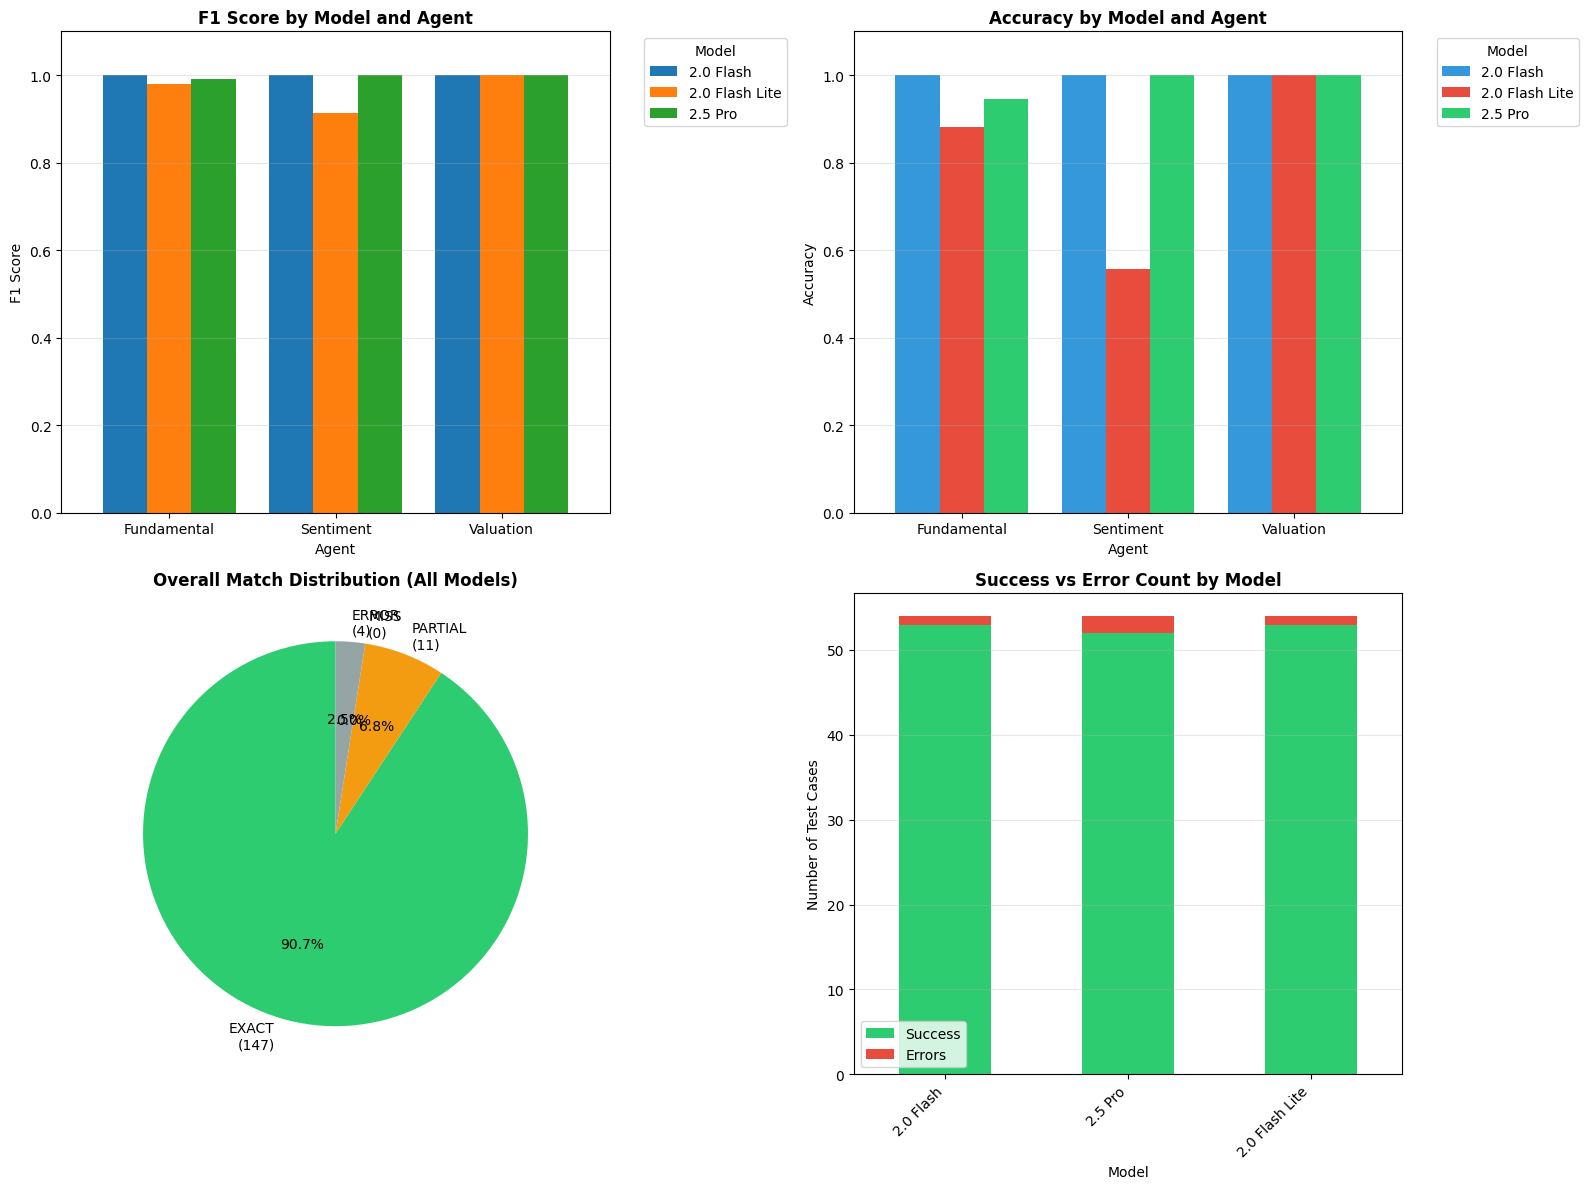

In [18]:
# Visualization - Multi-model comparison
import matplotlib.pyplot as plt
import seaborn as sns

# Create a comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: F1 Score by Model and Agent
ax1 = axes[0, 0]
plot_data = []
for model_name, model_results in all_results.items():
    for agent_name, result in model_results.items():
        if isinstance(result, dict) and "metrics" in result:
            plot_data.append({
                'Model': model_name.replace('gemini-', '').replace('-', ' ').title(),
                'Agent': agent_name.capitalize(),
                'F1 Score': result["metrics"].f1_score
            })

plot_df = pd.DataFrame(plot_data)
pivot_data = plot_df.pivot(index='Agent', columns='Model', values='F1 Score')
pivot_data.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_title('F1 Score by Model and Agent', fontweight='bold')
ax1.set_ylabel('F1 Score')
ax1.set_xlabel('Agent')
ax1.set_ylim(0, 1.1)
ax1.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(axis='y', alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=0)

# Plot 2: Accuracy by Model and Agent
ax2 = axes[0, 1]
plot_data2 = []
for model_name, model_results in all_results.items():
    for agent_name, result in model_results.items():
        if isinstance(result, dict) and "metrics" in result:
            plot_data2.append({
                'Model': model_name.replace('gemini-', '').replace('-', ' ').title(),
                'Agent': agent_name.capitalize(),
                'Accuracy': result["metrics"].accuracy
            })

plot_df2 = pd.DataFrame(plot_data2)
pivot_data2 = plot_df2.pivot(index='Agent', columns='Model', values='Accuracy')
pivot_data2.plot(kind='bar', ax=ax2, width=0.8, color=['#3498db', '#e74c3c', '#2ecc71'])
ax2.set_title('Accuracy by Model and Agent', fontweight='bold')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Agent')
ax2.set_ylim(0, 1.1)
ax2.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(axis='y', alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0)

# Plot 3: Overall match distribution across all models
ax3 = axes[1, 0]
match_counts = {"EXACT": 0, "PARTIAL": 0, "MISS": 0, "ERROR": 0}

for model_name, model_results in all_results.items():
    for agent_name, result in model_results.items():
        if isinstance(result, dict) and "results" in result:
            for r in result["results"]:
                match_counts[r["match"]] += 1

colors = {'EXACT': '#2ecc71', 'PARTIAL': '#f39c12', 'MISS': '#e74c3c', 'ERROR': '#95a5a6'}
wedges, texts, autotexts = ax3.pie(
    match_counts.values(),
    labels=[f"{k}\n({v})" for k, v in match_counts.items()],
    autopct='%1.1f%%',
    colors=[colors[k] for k in match_counts.keys()],
    startangle=90
)
ax3.set_title('Overall Match Distribution (All Models)', fontweight='bold')

# Plot 4: Error count by model
ax4 = axes[1, 1]
error_data = []
for model_name, model_results in all_results.items():
    total_errors = sum(result.get("error_count", 0) 
                      for result in model_results.values() 
                      if isinstance(result, dict))
    total_success = sum(result.get("successful_cases", 0) 
                       for result in model_results.values() 
                       if isinstance(result, dict))
    error_data.append({
        'Model': model_name.replace('gemini-', '').replace('-', ' ').title(),
        'Errors': total_errors,
        'Success': total_success
    })

error_df = pd.DataFrame(error_data)
error_df.plot(x='Model', y=['Success', 'Errors'], kind='bar', stacked=True, 
              ax=ax4, color=['#2ecc71', '#e74c3c'])
ax4.set_title('Success vs Error Count by Model', fontweight='bold')
ax4.set_ylabel('Number of Test Cases')
ax4.set_xlabel('Model')
ax4.legend(['Success', 'Errors'])
ax4.grid(axis='y', alpha=0.3)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()

# Save
viz_path = "results/tool_selection_evaluation.png"
plt.savefig(viz_path, dpi=150, bbox_inches='tight')
print(f"\n✓ Chart saved to {viz_path}")

plt.show()

## 8. Detailed Results Export

In [19]:
# Export detailed results to CSV
detailed_results = []

for model_name, model_results in all_results.items():
    for agent_name, result in model_results.items():
        if isinstance(result, dict) and "results" in result:
            for r in result["results"]:
                detailed_results.append({
                    "model": model_name,
                    "agent": agent_name,
                    "query": r["query"],
                    "description": r["description"],
                    "expected_tools": ", ".join(sorted(r["expected"])),
                    "actual_tools": ", ".join(sorted(r["actual"])),
                    "match": r["match"],
                    "success": r["success"],
                    "attempts": r.get("attempts", 0),
                    "error_type": r.get("error_type", ""),
                    "error": r.get("error", "")[:200] if r.get("error") else ""  # Truncate long errors
                })

detailed_df = pd.DataFrame(detailed_results)

# Create results directory if it doesn't exist
os.makedirs("results", exist_ok=True)

# Save to CSV
csv_path = "results/tool_selection_detailed_results.csv"
detailed_df.to_csv(csv_path, index=False)

print(f"✓ Detailed results saved to {csv_path}")
print(f"\nTotal test cases: {len(detailed_df)}")
print(f"\nMatch distribution:")
print(detailed_df['match'].value_counts())
print(f"\nError breakdown:")
error_df = detailed_df[detailed_df['match'] == 'ERROR']
if len(error_df) > 0:
    print(error_df['error_type'].value_counts())
else:
    print("  No errors!")
print(f"\nResults by model:")
print(detailed_df.groupby('model')['match'].value_counts().unstack(fill_value=0))

✓ Detailed results saved to results/tool_selection_detailed_results.csv

Total test cases: 162

Match distribution:
match
EXACT      147
PARTIAL     11
ERROR        4
Name: count, dtype: int64

Error breakdown:
error_type
OTHER_ERROR    2
API_ERROR      2
Name: count, dtype: int64

Results by model:
match                  ERROR  EXACT  PARTIAL
model                                       
gemini-2.0-flash           1     53        0
gemini-2.0-flash-lite      1     43       10
gemini-2.5-pro             2     51        1


In [20]:
# Export final summary metrics to JSON
metrics_export = {
    "evaluation_date": pd.Timestamp.now().isoformat(),
    "models_tested": MODELS_TO_TEST,
    "total_test_cases": len(detailed_df),
    "per_model_metrics": {}
}

# Export metrics for each model
for model_name, model_results in all_results.items():
    metrics_export["per_model_metrics"][model_name] = {
        "agents": {}
    }
    
    for agent_name, result in model_results.items():
        if isinstance(result, dict) and "metrics" in result:
            m = result["metrics"]
            metrics_export["per_model_metrics"][model_name]["agents"][agent_name] = {
                "accuracy": m.accuracy,
                "precision": m.precision,
                "recall": m.recall,
                "f1_score": m.f1_score,
                "exact_matches": m.exact_matches,
                "total_cases": m.total_cases,
                "error_count": result.get("error_count", 0),
                "successful_cases": result.get("successful_cases", 0)
            }

# Save final JSON
json_path = "results/tool_selection_metrics.json"
with open(json_path, "w") as f:
    json.dump(metrics_export, f, indent=2)

print(f"✓ Final metrics exported to {json_path}")

# Save summary tables
summary_csv_path = "results/tool_selection_summary.csv"
summary_df.to_csv(summary_csv_path, index=False)
print(f"✓ Summary table saved to {summary_csv_path}")

model_comparison_csv_path = "results/tool_selection_model_comparison.csv"
model_comparison_df.to_csv(model_comparison_csv_path, index=False)
print(f"✓ Model comparison saved to {model_comparison_csv_path}")

print("\n" + "="*70)
print("ALL RESULTS SAVED SUCCESSFULLY")
print("="*70)
print("Files generated:")
print(f"  1. {json_path} - Complete metrics")
print(f"  2. {csv_path} - Detailed test case results")
print(f"  3. {summary_csv_path} - Summary table")
print(f"  4. {model_comparison_csv_path} - Model comparison table")
print(f"  5. results/tool_selection_results_temp.json - Incremental backup")
print("="*70)

✓ Final metrics exported to results/tool_selection_metrics.json
✓ Summary table saved to results/tool_selection_summary.csv
✓ Model comparison saved to results/tool_selection_model_comparison.csv

ALL RESULTS SAVED SUCCESSFULLY
Files generated:
  1. results/tool_selection_metrics.json - Complete metrics
  2. results/tool_selection_detailed_results.csv - Detailed test case results
  3. results/tool_selection_summary.csv - Summary table
  4. results/tool_selection_model_comparison.csv - Model comparison table
  5. results/tool_selection_results_temp.json - Incremental backup


## 9. Error Analysis

In [21]:
# Analyze mismatches across all models
print("\n" + "="*70)
print("ERROR ANALYSIS - Cases with Mismatches")
print("="*70)

for model_name, model_results in all_results.items():
    print(f"\n{'='*70}")
    print(f"MODEL: {model_name}")
    print(f"{'='*70}")
    
    for agent_name, result in model_results.items():
        if isinstance(result, dict) and "results" in result:
            mismatches = [r for r in result["results"] if r["match"] != "EXACT"]
            
            if mismatches:
                print(f"\n{agent_name.upper()} Agent Mismatches ({len(mismatches)} cases):")
                print("-" * 50)
                
                for r in mismatches:
                    print(f"\n  Query: {r['query'][:70]}..." if len(r['query']) > 70 else f"\n  Query: {r['query']}")
                    print(f"  Match Type: {r['match']}")
                    print(f"  Expected: {sorted(r['expected'])}")
                    print(f"  Actual:   {sorted(r['actual'])}")
                    
                    if r['match'] == 'ERROR':
                        print(f"  Error Type: {r.get('error_type', 'UNKNOWN')}")
                        print(f"  Error: {r.get('error', 'Unknown error')[:100]}")
                    else:
                        missing = r['expected'] - r['actual']
                        extra = r['actual'] - r['expected']
                        
                        if missing:
                            print(f"  Missing:  {sorted(missing)}")
                        if extra:
                            print(f"  Extra:    {sorted(extra)}")
            else:
                print(f"\n{agent_name.upper()} Agent: ✓ All tests passed (no mismatches)")


ERROR ANALYSIS - Cases with Mismatches

MODEL: gemini-2.0-flash

FUNDAMENTAL Agent Mismatches (1 cases):
--------------------------------------------------

  Query: Analyze YTL Corporation's revenue trends
  Match Type: ERROR
  Expected: ['finance_report_pull', 'rag_analysis', 'resolve_ticker_symbol']
  Actual:   []
  Error Type: OTHER_ERROR
  Error: The resolution lifetime expired after 21.610 seconds: Server Do53:192.168.100.1@53 answered The DNS 

SENTIMENT Agent: ✓ All tests passed (no mismatches)

VALUATION Agent: ✓ All tests passed (no mismatches)

MODEL: gemini-2.5-pro

FUNDAMENTAL Agent Mismatches (1 cases):
--------------------------------------------------

  Query: Calculate the current ratio for IHH Healthcare
  Match Type: PARTIAL
  Expected: ['finance_report_pull', 'rag_analysis', 'resolve_ticker_symbol']
  Actual:   ['finance_report_pull', 'resolve_ticker_symbol']
  Missing:  ['rag_analysis']

SENTIMENT Agent Mismatches (2 cases):
--------------------------------------

## 10. Summary Report

In [22]:
# Generate final summary report
print("\n" + "="*70)
print("TOOL SELECTION EVALUATION - FINAL REPORT")
print("="*70)

print(f"\nEvaluation Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Models Tested: {len(MODELS_TO_TEST)}")
print(f"Test Cases per Model: {aggregate_metrics.total_cases // len(MODELS_TO_TEST)}")
print(f"Total Test Runs: {sum(len(r['results']) for m in all_results.values() for r in m.values() if isinstance(r, dict) and 'results' in r)}")

# Per-model summary
for model_name, model_results in all_results.items():
    print("\n" + "-"*70)
    print(f"MODEL: {model_name}")
    print("-"*70)
    
    for agent_name, result in model_results.items():
        if isinstance(result, dict) and "metrics" in result:
            m = result["metrics"]
            print(f"\n{agent_name.capitalize()} Agent:")
            print(f"  Accuracy:     {m.accuracy:.2%}")
            print(f"  Precision:    {m.precision:.2%}")
            print(f"  Recall:       {m.recall:.2%}")
            print(f"  F1 Score:     {m.f1_score:.2%}")
            print(f"  Exact Match:  {m.exact_matches}/{m.total_cases}")
            print(f"  Errors:       {result.get('error_count', 0)}")

print("\n" + "="*70)
print("AGGREGATE RESULTS (All Models & Agents Combined)")
print("="*70)
print(f"  Accuracy:     {aggregate_metrics.accuracy:.2%}")
print(f"  Precision:    {aggregate_metrics.precision:.2%}")
print(f"  Recall:       {aggregate_metrics.recall:.2%}")
print(f"  F1 Score:     {aggregate_metrics.f1_score:.2%}")
print(f"  Exact Match:  {aggregate_metrics.exact_matches}/{aggregate_metrics.total_cases}")

print("\n" + "="*70)
print("FILES GENERATED")
print("="*70)
print("  1. results/tool_selection_evaluation.png - Visual comparison")
print("  2. results/tool_selection_detailed_results.csv - All test case results")
print("  3. results/tool_selection_metrics.json - Complete metrics")
print("  4. results/tool_selection_summary.csv - Summary table")
print("  5. results/tool_selection_model_comparison.csv - Model comparison")
print("  6. results/tool_selection_results_temp.json - Incremental backup")
print("="*70)


TOOL SELECTION EVALUATION - FINAL REPORT

Evaluation Date: 2026-01-07 22:04:46
Models Tested: 3
Test Cases per Model: 52
Total Test Runs: 162

----------------------------------------------------------------------
MODEL: gemini-2.0-flash
----------------------------------------------------------------------

Fundamental Agent:
  Accuracy:     100.00%
  Precision:    100.00%
  Recall:       100.00%
  F1 Score:     100.00%
  Exact Match:  17/17
  Errors:       1

Sentiment Agent:
  Accuracy:     100.00%
  Precision:    100.00%
  Recall:       100.00%
  F1 Score:     100.00%
  Exact Match:  18/18
  Errors:       0

Valuation Agent:
  Accuracy:     100.00%
  Precision:    100.00%
  Recall:       100.00%
  F1 Score:     100.00%
  Exact Match:  18/18
  Errors:       0

----------------------------------------------------------------------
MODEL: gemini-2.5-pro
----------------------------------------------------------------------

Fundamental Agent:
  Accuracy:     94.44%
  Precision:    10